In [17]:
#We import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
#We set the path
path = "C:/Users/lunam/OzonProject/"

In [19]:
#This is a function to initiate our walk-forward predictions. The code was taken from the Forecasting Notebook of Module 8
def evaluate_forecast(train, test, shifts, train_tail, model):
    history = train.copy()
    hourly_predictions_df = pd.DataFrame(columns=["Day", "Hour", "Predicted_Ozon", "Actual_Ozon"])
    performance_collector = []


    for d in test["day_of_year"].unique():
        dat = history.tail(train_tail)  
        dat = pd.concat([dat, test[test["day_of_year"] == d]])  

        shifted_data = {"lag_{}_hour".format(hour_shift): dat["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts}  # lag training data
        shifted_data = pd.DataFrame(shifted_data)

        dat = pd.concat([dat[["Luftdruck_STA", "Lufttemp_STA", "Windgeschw_STA", "StampfenbachstrOzon", "AnzFahrzeuge_STA", "hour_of_day", "day_of_week", "day_of_year", "month", "year"]], shifted_data], axis=1)
        
        dat = dat.dropna()  

        pred_dat = dat.drop("StampfenbachstrOzon", axis=1)

        y_pred = model.predict(pred_dat)
        actual = test[test["day_of_year"] == d]["StampfenbachstrOzon"]
        
        for h in range(24):
            actual_hourly = test[(test["hour_of_day"] == h) & (test["day_of_year"] == d)]["StampfenbachstrOzon"]
            y_pred_hourly = y_pred[h::24]  # Extract predictions for the current hour from the 24-hour prediction
            print(f'Day {d}, Hour {h}, y_pred_hourly: {y_pred_hourly.tolist()}')
            hourly_predictions_df = pd.concat([hourly_predictions_df, pd.DataFrame({"Day": [d], "Hour": [h], "Predicted_Ozon": [y_pred_hourly.tolist()], "Actual_Ozon": [actual_hourly.tolist()]})], ignore_index=True)
        
        
        performance_collector.append(mean_squared_error(actual, y_pred, squared=False))

        history = pd.concat([history, dat], ignore_index=True)

    return performance_collector, hourly_predictions_df


In [20]:
#Function for variable importance plot (module 4)
def plot_variable_importance(model, X_train):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp=DataFrame({"imp":model.feature_importances_, "names":X_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(imp.shape[0]/6,imp.shape[0]/5), dpi=300) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show() 

In [21]:
#Import the dataset
df_sta = pd.read_csv(path + "sta_data.csv", low_memory=False)
df_sta

datetime  Luftdruck_STA  Lufttemp_STA  Windgeschw_STA  \
0      2021-01-01 01:00:00          954.0           2.1             4.7   
1      2021-01-01 02:00:00          954.4           2.3             3.2   
2      2021-01-01 03:00:00          954.6           2.0             2.5   
3      2021-01-01 04:00:00          954.6           2.3             2.2   
4      2021-01-01 05:00:00          954.8           2.3             2.9   
...                    ...            ...           ...             ...   
25530  2023-11-30 19:00:00          948.9           3.2             2.9   
25531  2023-11-30 20:00:00          948.9           3.8             5.4   
25532  2023-11-30 21:00:00          949.1           4.3             6.8   
25533  2023-11-30 22:00:00          949.2           3.8             5.4   
25534  2023-11-30 23:00:00          949.1           4.6             4.7   

       StampfenbachstrOzon  AnzFahrzeuge_STA  hour_of_day  day_of_week  \
0                     8.51            1320.0            1            5   
1                     5.34             919.0            2            5   
2                     7.54             617.0            3            5   
3                    31.30             445.0            4            5   
4                    40.87             371.0            5            5   
...                    ...               ...          ...          ...   
25530                 2.90            2742.0           19            4   
25531                 1.99            2357.0           20            4   
25532                 3.28            1946.0           21            4   
25533                 6.96            1808.0           22            4   
25534                 2.42            1240.0           23            4   

       day_of_year  month  year  
0                1      1  2021  
1                1      1  2021  
2                1      1  2021  
3                1      1  2021  
4                1      1  2021  
...            ...    ...   ...  
25530          334     11  2023  
25531          334     11  2023  
25532          334     11  2023  
25533          334     11  2023  
25534          334     11  2023  

[25535 rows x 11 columns]

In [22]:
# set the column 'datetime' as index
df_sta['datetime'] = pd.to_datetime(df_sta['datetime'])
df_sta.set_index('datetime', inplace=True)

# 72 Stunden Lags und N_Estimators 200

In [23]:
test1 = df_sta[-8640:] # get last year
train1 = df_sta[0:-8640] # get data until first day of testing day

In [24]:
shifts1 = np.arange(24, 73).astype(int) #we set lags from 24 to 72 (1 day and 3 days)

In [25]:
#We create the lag values
shifted_data1 = {"lag_{}_hour".format(hour_shift): train1["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts1}

#We make a dataset with the lag values
shifted_data1 = pd.DataFrame(shifted_data1)
shifted_data1

lag_24_hour  lag_25_hour  lag_26_hour  lag_27_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         2.01         2.29         2.33         2.75   
2022-12-05 20:00:00         1.86         2.01         2.29         2.33   
2022-12-05 21:00:00         3.06         1.86         2.01         2.29   
2022-12-05 22:00:00         4.73         3.06         1.86         2.01   
2022-12-05 23:00:00         6.75         4.73         3.06         1.86   

                     lag_28_hour  lag_29_hour  lag_30_hour  lag_31_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         5.11         6.95         7.03         6.65   
2022-12-05 20:00:00         2.75         5.11         6.95         7.03   
2022-12-05 21:00:00         2.33         2.75         5.11         6.95   
2022-12-05 22:00:00         2.29         2.33         2.75         5.11   
2022-12-05 23:00:00         2.01         2.29         2.33         2.75   

                     lag_32_hour  lag_33_hour  ...  lag_63_hour  lag_64_hour  \
datetime                                       ...                             
2021-01-01 01:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN  ...          NaN          NaN   
...                          ...          ...  ...          ...          ...   
2022-12-05 19:00:00         6.37         5.79  ...         9.42         8.94   
2022-12-05 20:00:00         6.65         6.37  ...        10.09         9.42   
2022-12-05 21:00:00         7.03         6.65  ...        10.67        10.09   
2022-12-05 22:00:00         6.95         7.03  ...        13.06        10.67   
2022-12-05 23:00:00         5.11         6.95  ...        12.05        13.06   

                     lag_65_hour  lag_66_hour  lag_67_hour  lag_68_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         8.56         3.80         2.48         2.89   
2022-12-05 20:00:00         8.94         8.56         3.80         2.48   
2022-12-05 21:00:00         9.42         8.94         8.56         3.80   
2022-12-05 22:00:00        10.09         9.42         8.94         8.56   
2022-12-05 23:00:00        10.67        10.09         9.42         8.94   

                     lag_69_hour  lag_70_hour  lag_7

In [26]:
#We create our training set with the shifted data
train1 = pd.concat([train1,shifted_data1],axis=1)
train1

Luftdruck_STA  Lufttemp_STA  Windgeschw_STA  \
datetime                                                           
2021-01-01 01:00:00          954.0           2.1             4.7   
2021-01-01 02:00:00          954.4           2.3             3.2   
2021-01-01 03:00:00          954.6           2.0             2.5   
2021-01-01 04:00:00          954.6           2.3             2.2   
2021-01-01 05:00:00          954.8           2.3             2.9   
...                            ...           ...             ...   
2022-12-05 19:00:00          968.6           5.7             3.6   
2022-12-05 20:00:00          968.9           5.3             2.9   
2022-12-05 21:00:00          969.0           4.4             3.6   
2022-12-05 22:00:00          969.0           4.0             3.2   
2022-12-05 23:00:00          968.9           3.5             1.4   

                     StampfenbachstrOzon  AnzFahrzeuge_STA  hour_of_day  \
datetime                                                                  
2021-01-01 01:00:00                 8.51            1320.0            1   
2021-01-01 02:00:00                 5.34             919.0            2   
2021-01-01 03:00:00                 7.54             617.0            3   
2021-01-01 04:00:00                31.30             445.0            4   
2021-01-01 05:00:00                40.87             371.0            5   
...                                  ...               ...          ...   
2022-12-05 19:00:00                22.99            2781.0           19   
2022-12-05 20:00:00                22.99            2204.0           20   
2022-12-05 21:00:00                12.72            2209.0           21   
2022-12-05 22:00:00                 4.00            1971.0           22   
2022-12-05 23:00:00                 2.53            1214.0           23   

                     day_of_week  day_of_year  month  year  ...  lag_63_hour  \
datetime                                                    ...                
2021-01-01 01:00:00            5            1      1  2021  ...          NaN   
2021-01-01 02:00:00            5            1      1  2021  ...          NaN   
2021-01-01 03:00:00            5            1      1  2021  ...          NaN   
2021-01-01 04:00:00            5            1      1  2021  ...          NaN   
2021-01-01 05:00:00            5            1      1  2021  ...          NaN   
...                          ...          ...    ...   ...  ...          ...   
2022-12-05 19:00:00            1          339     12  2022  ...         9.42   
2022-12-05 20:00:00            1          339     12  2022  ...        10.09   
2022-12-05 21:00:00            1          339     12  2022  ...        10.67   
2022-12-05 22:00:00            1          339     12  2022  ...        13.06   
2022-12-05 23:00:00            1          339     12  2022  ...        12.05   

                     lag_64_hour  lag_65_hour  lag_66_hour  lag_67_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         8.94         8.56         3.80         2.48   
2022-12-05 20:00:00         9.42         8.94         8.56         3.80   
2022-12-05 21:00:00        10.09         9.42         8.94         8.56   
2022-12-05 22:00:00        10.67        10.09         9.42         8.94   
2022-12-05 23:00:00        13.06        10.67        10.09         9.42   

                     lag_68_hour  lag_69_hour  lag_70_hour  lag_71_hour  \
datetime                                                            

In [27]:
#We drop the NaN values
train1 = train1.dropna()

In [28]:
#We create our X_train and y_train sets
X_train1 = train1.drop("StampfenbachstrOzon", axis=1)
y_train1 = train1["StampfenbachstrOzon"]

In [29]:
#We fit our model
forecast_forest_sta1 = RandomForestRegressor(n_estimators=200, random_state=1)
forecast_forest_sta1.fit(X_train1, y_train1)

RandomForestRegressor(n_estimators=200, random_state=1)

In [30]:
#We apply our forecasting function
performance_collector1, predictions_df1 = evaluate_forecast(train1, test1, shifts1, 72, forecast_forest_sta1)

Day 340, Hour 0, y_pred_hourly: [5.609249999999998]
Day 340, Hour 1, y_pred_hourly: [9.959650000000007]
Day 340, Hour 2, y_pred_hourly: [9.5021]
Day 340, Hour 3, y_pred_hourly: [10.473150000000002]
Day 340, Hour 4, y_pred_hourly: [6.811300000000001]
Day 340, Hour 5, y_pred_hourly: [13.96512499999999]
Day 340, Hour 6, y_pred_hourly: [14.879799999999996]
Day 340, Hour 7, y_pred_hourly: [18.139850000000003]
Day 340, Hour 8, y_pred_hourly: [15.75930000000001]
Day 340, Hour 9, y_pred_hourly: [13.163099999999995]
Day 340, Hour 10, y_pred_hourly: [21.174350000000015]
Day 340, Hour 11, y_pred_hourly: [19.78605]
Day 340, Hour 12, y_pred_hourly: [22.082949999999986]
Day 340, Hour 13, y_pred_hourly: [23.36629999999999]
Day 340, Hour 14, y_pred_hourly: [21.825349999999993]
Day 340, Hour 15, y_pred_hourly: [20.229366666666657]
Day 340, Hour 16, y_pred_hourly: [20.839183333333345]
Day 340, Hour 17, y_pred_hourly: [18.87809999999997]
Day 340, Hour 18, y_pred_hourly: [21.145349999999997]
Day 340, Hour

In [31]:
#We print our mean performance collector
print(np.mean(performance_collector1))

15.472216930810115


In [32]:
#We print our predictions
print(predictions_df1)

      Day Hour        Predicted_Ozon Actual_Ozon
0     340    0   [5.609249999999998]      [3.65]
1     340    1   [9.959650000000007]      [2.87]
2     340    2              [9.5021]     [12.55]
3     340    3  [10.473150000000002]     [28.25]
4     340    4   [6.811300000000001]      [7.35]
...   ...  ...                   ...         ...
8635  334   19             [19.1633]       [2.9]
8636  334   20             [33.4686]      [1.99]
8637  334   21  [32.467250000000014]      [3.28]
8638  334   22   [33.65506666666669]      [6.96]
8639  334   23  [25.735108333333354]      [2.42]

[8640 rows x 4 columns]


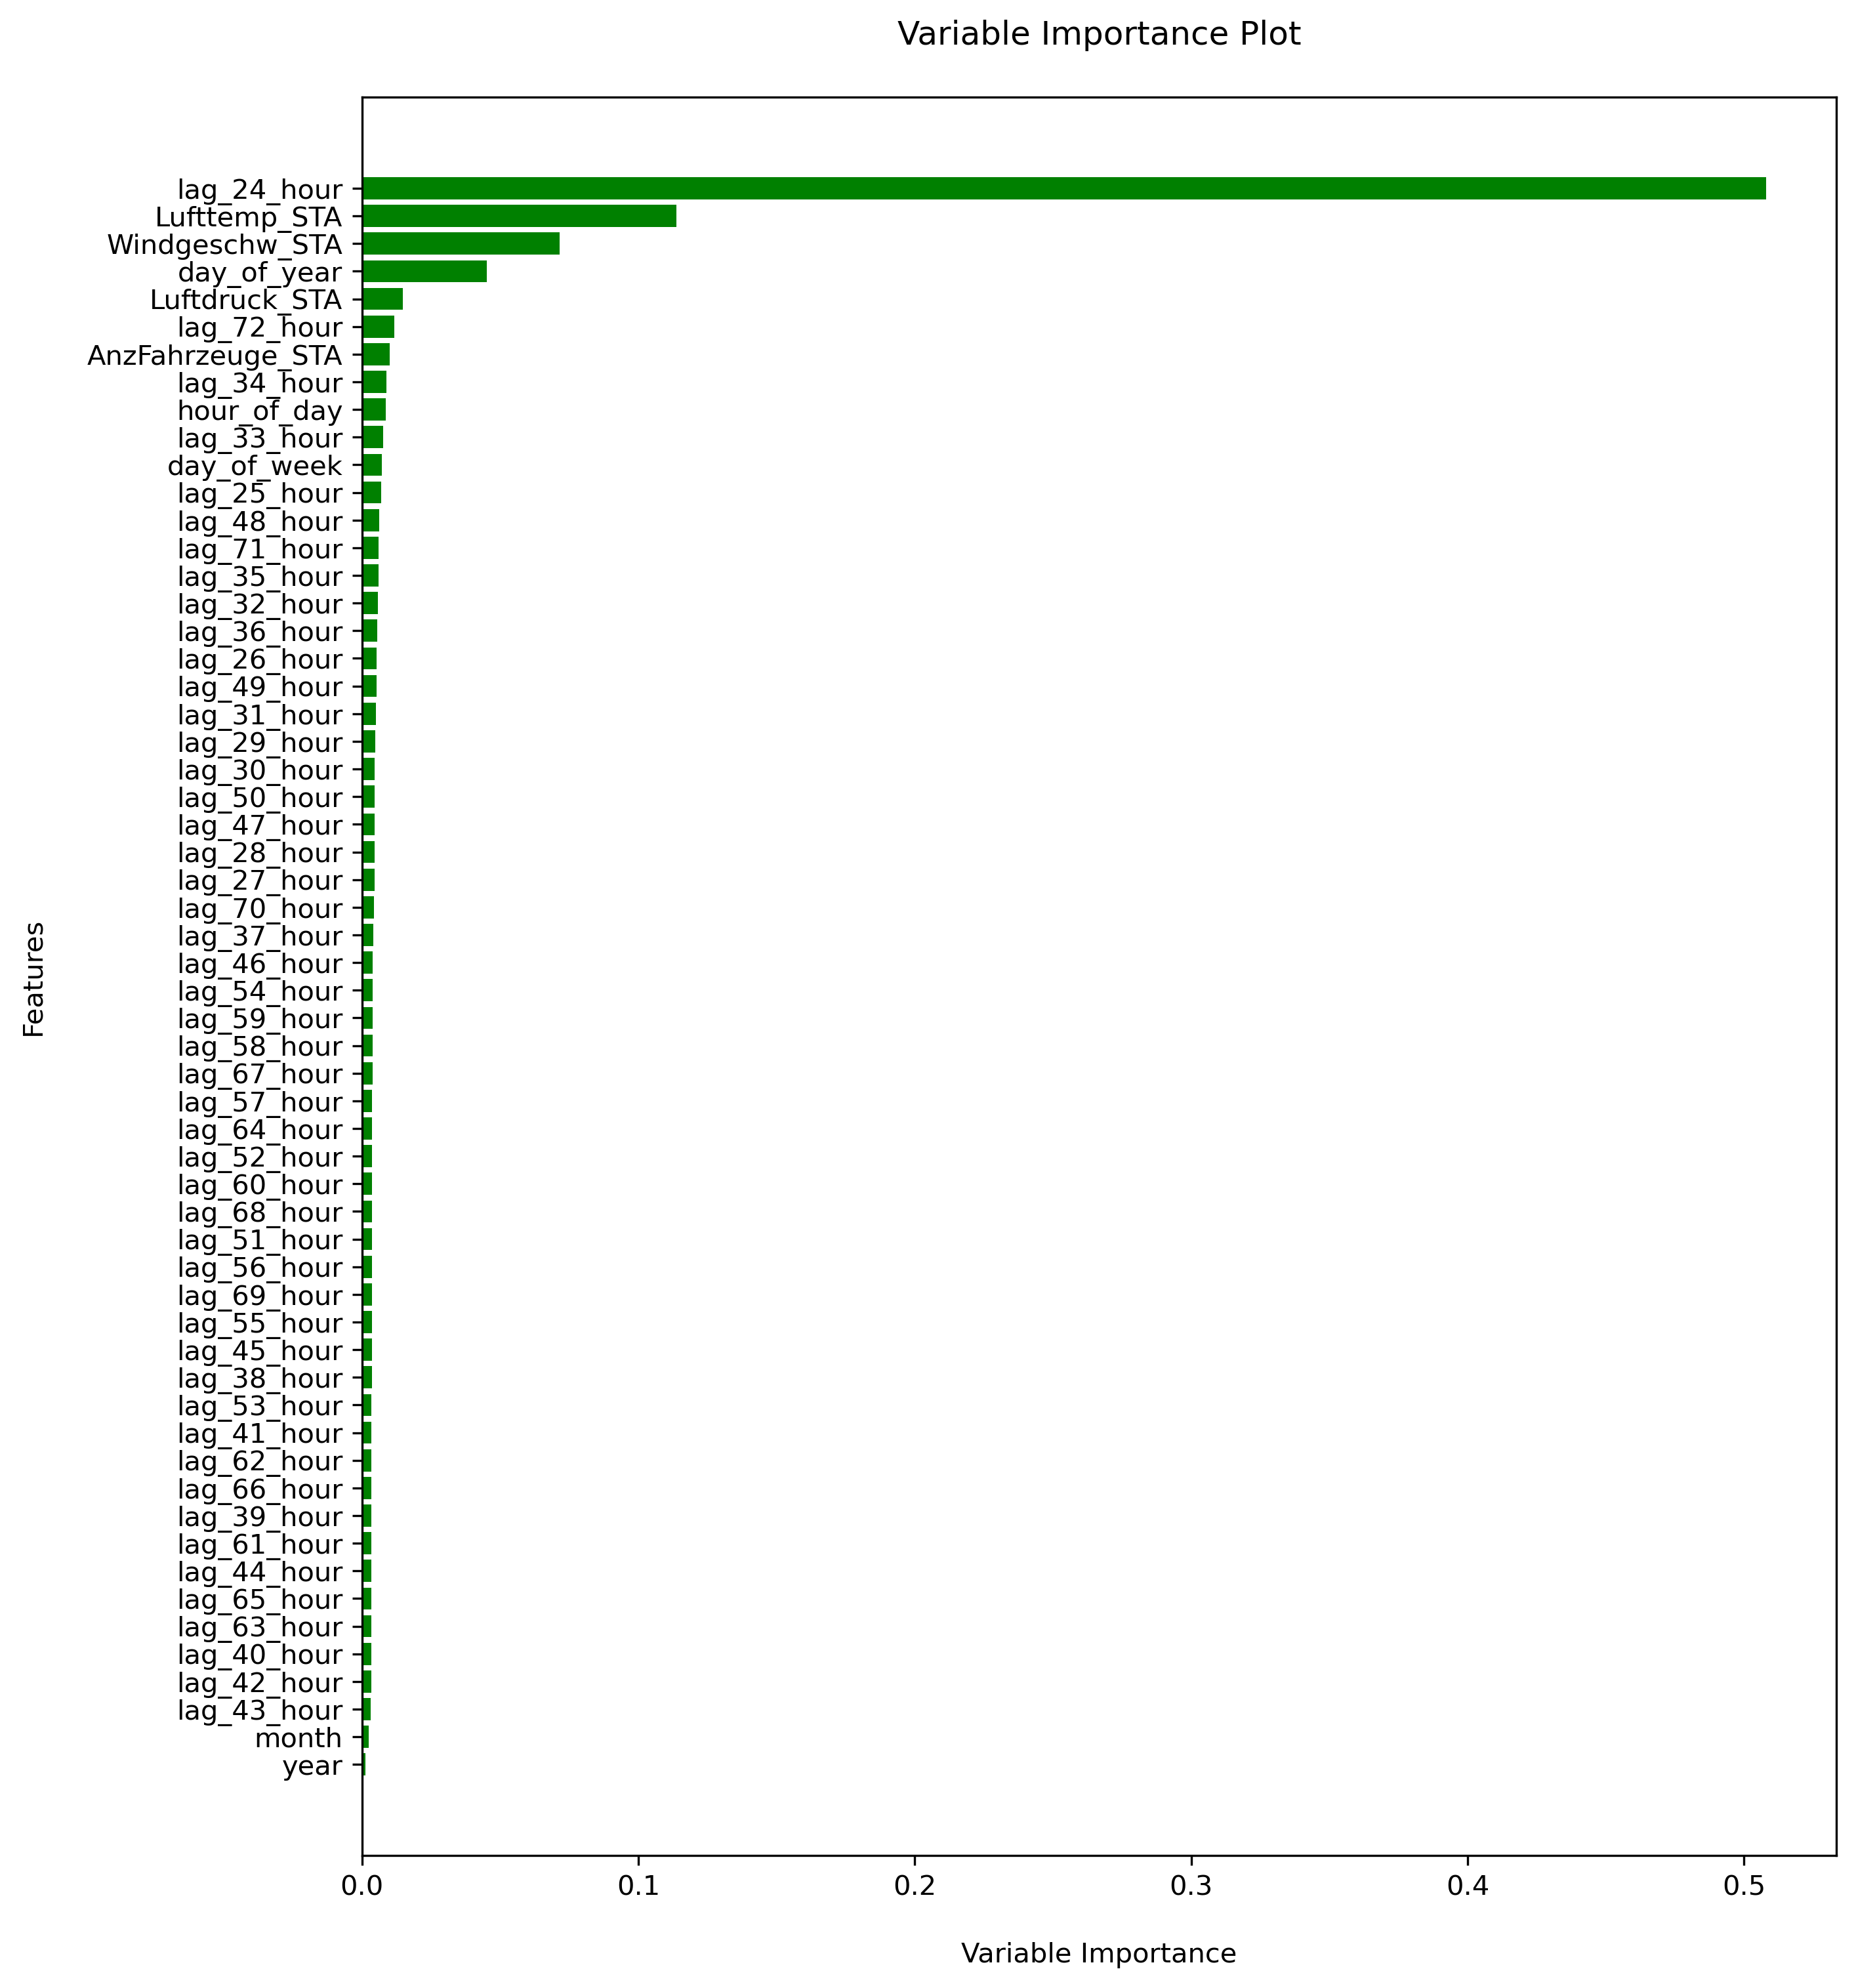

In [33]:
#We print our variable importance plot
plot_variable_importance(forecast_forest_sta1, X_train1)

Aus dem Variable Importance Plot ergibt sich, dass die Variablen lag 24h, Lufttemperatur, Windgeschwindigkeit, day of the year und Luftdruck am wichtigsten sind.

In [34]:
#We need to remove the squared brackets in the dataset 
predictions_df1 = predictions_df1.explode('Predicted_Ozon')
predictions_df1 = predictions_df1.explode('Actual_Ozon')
#The function explode was found through ChatGPT. This function is also used later in the notebook.
#Question: How can we remove squared brackets in a dataframe?
# Reset the index
predictions_df1.reset_index(drop=True, inplace=True)

# Display the DataFrame after modification
print(predictions_df1)

      Day Hour Predicted_Ozon Actual_Ozon
0     340    0        5.60925        3.65
1     340    1        9.95965        2.87
2     340    2         9.5021       12.55
3     340    3       10.47315       28.25
4     340    4         6.8113        7.35
...   ...  ...            ...         ...
8635  334   19        19.1633         2.9
8636  334   20        33.4686        1.99
8637  334   21       32.46725        3.28
8638  334   22      33.655067        6.96
8639  334   23      25.735108        2.42

[8640 rows x 4 columns]


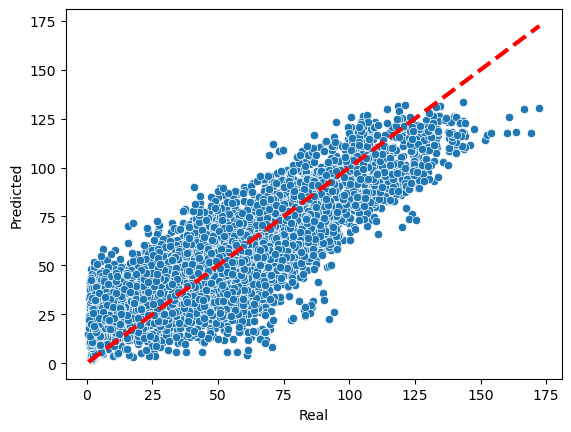

In [35]:
import seaborn as sns
#Visual representation of the results
#This code comes from an old assignment (see also for later)
data_rf1 = pd.DataFrame({'Real': predictions_df1['Actual_Ozon'], 'Predicted': predictions_df1['Predicted_Ozon']})

sns.scatterplot(data=data_rf1, x='Real', y='Predicted')
plt.plot([test1['StampfenbachstrOzon'].min(), test1['StampfenbachstrOzon'].max()], [test1['StampfenbachstrOzon'].min(), test1['StampfenbachstrOzon'].max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

Das Modell zeigt, dass es eine Ausgewogenheit zwischen Overestimation und Underestimation. Bei den Ozon Datenpunkten, die sehr hihe Werte aufweisen, wurden diese underestimated.

# N_Estimators = 300

In [36]:
test2 = df_sta[-8640:] # get last year
train2 = df_sta[0:-8640] # get data until first day of testing day

In [37]:
shifts2 = np.arange(24, 73).astype(int) #we set lags from 24 to 72 (1 day and 3 days)

In [38]:
#We create the lag values
shifted_data2 = {"lag_{}_hour".format(hour_shift): train2["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts2}

#We make a dataset with the lag values
shifted_data2 = pd.DataFrame(shifted_data2)
shifted_data2

lag_24_hour  lag_25_hour  lag_26_hour  lag_27_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         2.01         2.29         2.33         2.75   
2022-12-05 20:00:00         1.86         2.01         2.29         2.33   
2022-12-05 21:00:00         3.06         1.86         2.01         2.29   
2022-12-05 22:00:00         4.73         3.06         1.86         2.01   
2022-12-05 23:00:00         6.75         4.73         3.06         1.86   

                     lag_28_hour  lag_29_hour  lag_30_hour  lag_31_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         5.11         6.95         7.03         6.65   
2022-12-05 20:00:00         2.75         5.11         6.95         7.03   
2022-12-05 21:00:00         2.33         2.75         5.11         6.95   
2022-12-05 22:00:00         2.29         2.33         2.75         5.11   
2022-12-05 23:00:00         2.01         2.29         2.33         2.75   

                     lag_32_hour  lag_33_hour  ...  lag_63_hour  lag_64_hour  \
datetime                                       ...                             
2021-01-01 01:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN  ...          NaN          NaN   
...                          ...          ...  ...          ...          ...   
2022-12-05 19:00:00         6.37         5.79  ...         9.42         8.94   
2022-12-05 20:00:00         6.65         6.37  ...        10.09         9.42   
2022-12-05 21:00:00         7.03         6.65  ...        10.67        10.09   
2022-12-05 22:00:00         6.95         7.03  ...        13.06        10.67   
2022-12-05 23:00:00         5.11         6.95  ...        12.05        13.06   

                     lag_65_hour  lag_66_hour  lag_67_hour  lag_68_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         8.56         3.80         2.48         2.89   
2022-12-05 20:00:00         8.94         8.56         3.80         2.48   
2022-12-05 21:00:00         9.42         8.94         8.56         3.80   
2022-12-05 22:00:00        10.09         9.42         8.94         8.56   
2022-12-05 23:00:00        10.67        10.09         9.42         8.94   

                     lag_69_hour  lag_70_hour  lag_7

In [39]:
train2 = pd.concat([train2,shifted_data2],axis=1)
train2.head()

Luftdruck_STA  Lufttemp_STA  Windgeschw_STA  \
datetime                                                           
2021-01-01 01:00:00          954.0           2.1             4.7   
2021-01-01 02:00:00          954.4           2.3             3.2   
2021-01-01 03:00:00          954.6           2.0             2.5   
2021-01-01 04:00:00          954.6           2.3             2.2   
2021-01-01 05:00:00          954.8           2.3             2.9   

                     StampfenbachstrOzon  AnzFahrzeuge_STA  hour_of_day  \
datetime                                                                  
2021-01-01 01:00:00                 8.51            1320.0            1   
2021-01-01 02:00:00                 5.34             919.0            2   
2021-01-01 03:00:00                 7.54             617.0            3   
2021-01-01 04:00:00                31.30             445.0            4   
2021-01-01 05:00:00                40.87             371.0            5   

                     day_of_week  day_of_year  month  year  ...  lag_63_hour  \
datetime                                                    ...                
2021-01-01 01:00:00            5            1      1  2021  ...          NaN   
2021-01-01 02:00:00            5            1      1  2021  ...          NaN   
2021-01-01 03:00:00            5            1      1  2021  ...          NaN   
2021-01-01 04:00:00            5            1      1  2021  ...          NaN   
2021-01-01 05:00:00            5            1      1  2021  ...          NaN   

                     lag_64_hour  lag_65_hour  lag_66_hour  lag_67_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   

                     lag_68_hour  lag_69_hour  lag_70_hour  lag_71_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   

                     lag_72_hour  
datetime                          
2021-01-01 01:00:00          NaN  
2021-01-01 02:00:00          NaN  
2021-01-01 03:00:00          NaN  
2021-01-01 04:00:00          NaN  
2021-01-01 05:00:00          NaN  

[5 rows x 59 columns]

In [40]:
#We drop the NaN values
train2 = train2.dropna()

In [41]:
#We create our X_train and y_train sets
X_train2 = train2.drop("StampfenbachstrOzon", axis=1)
y_train2 = train2["StampfenbachstrOzon"]

In [42]:
#We fit our model
forecast_forest_sta2 = RandomForestRegressor(n_estimators=300, random_state=1)
forecast_forest_sta2.fit(X_train2, y_train2)

RandomForestRegressor(n_estimators=300, random_state=1)

In [43]:
#We apply our forecasting function
performance_collector2, predictions_df2 = evaluate_forecast(train2, test2, shifts2, 72, forecast_forest_sta2)

Day 340, Hour 0, y_pred_hourly: [5.850699999999998]
Day 340, Hour 1, y_pred_hourly: [10.584500000000002]
Day 340, Hour 2, y_pred_hourly: [9.84413333333333]
Day 340, Hour 3, y_pred_hourly: [10.744066666666667]
Day 340, Hour 4, y_pred_hourly: [7.063066666666676]
Day 340, Hour 5, y_pred_hourly: [14.25601666666665]
Day 340, Hour 6, y_pred_hourly: [14.763766666666667]
Day 340, Hour 7, y_pred_hourly: [18.38053333333334]
Day 340, Hour 8, y_pred_hourly: [16.42253333333335]
Day 340, Hour 9, y_pred_hourly: [13.351266666666666]
Day 340, Hour 10, y_pred_hourly: [21.604666666666674]
Day 340, Hour 11, y_pred_hourly: [18.968200000000017]
Day 340, Hour 12, y_pred_hourly: [22.340733333333336]
Day 340, Hour 13, y_pred_hourly: [23.359166666666663]
Day 340, Hour 14, y_pred_hourly: [22.635866666666676]
Day 340, Hour 15, y_pred_hourly: [20.830177777777774]
Day 340, Hour 16, y_pred_hourly: [21.289688888888904]
Day 340, Hour 17, y_pred_hourly: [18.883433333333322]
Day 340, Hour 18, y_pred_hourly: [21.06748888

In [44]:
#We print our mean performance collector
print(np.mean(performance_collector2))

15.453243711640653


In [45]:
#We print our predictions
print(predictions_df2)

      Day Hour        Predicted_Ozon Actual_Ozon
0     340    0   [5.850699999999998]      [3.65]
1     340    1  [10.584500000000002]      [2.87]
2     340    2    [9.84413333333333]     [12.55]
3     340    3  [10.744066666666667]     [28.25]
4     340    4   [7.063066666666676]      [7.35]
...   ...  ...                   ...         ...
8635  334   19  [18.627366666666692]       [2.9]
8636  334   20  [33.985533333333336]      [1.99]
8637  334   21   [33.07266666666667]      [3.28]
8638  334   22   [34.69650158730161]      [6.96]
8639  334   23   [26.55680714285716]      [2.42]

[8640 rows x 4 columns]


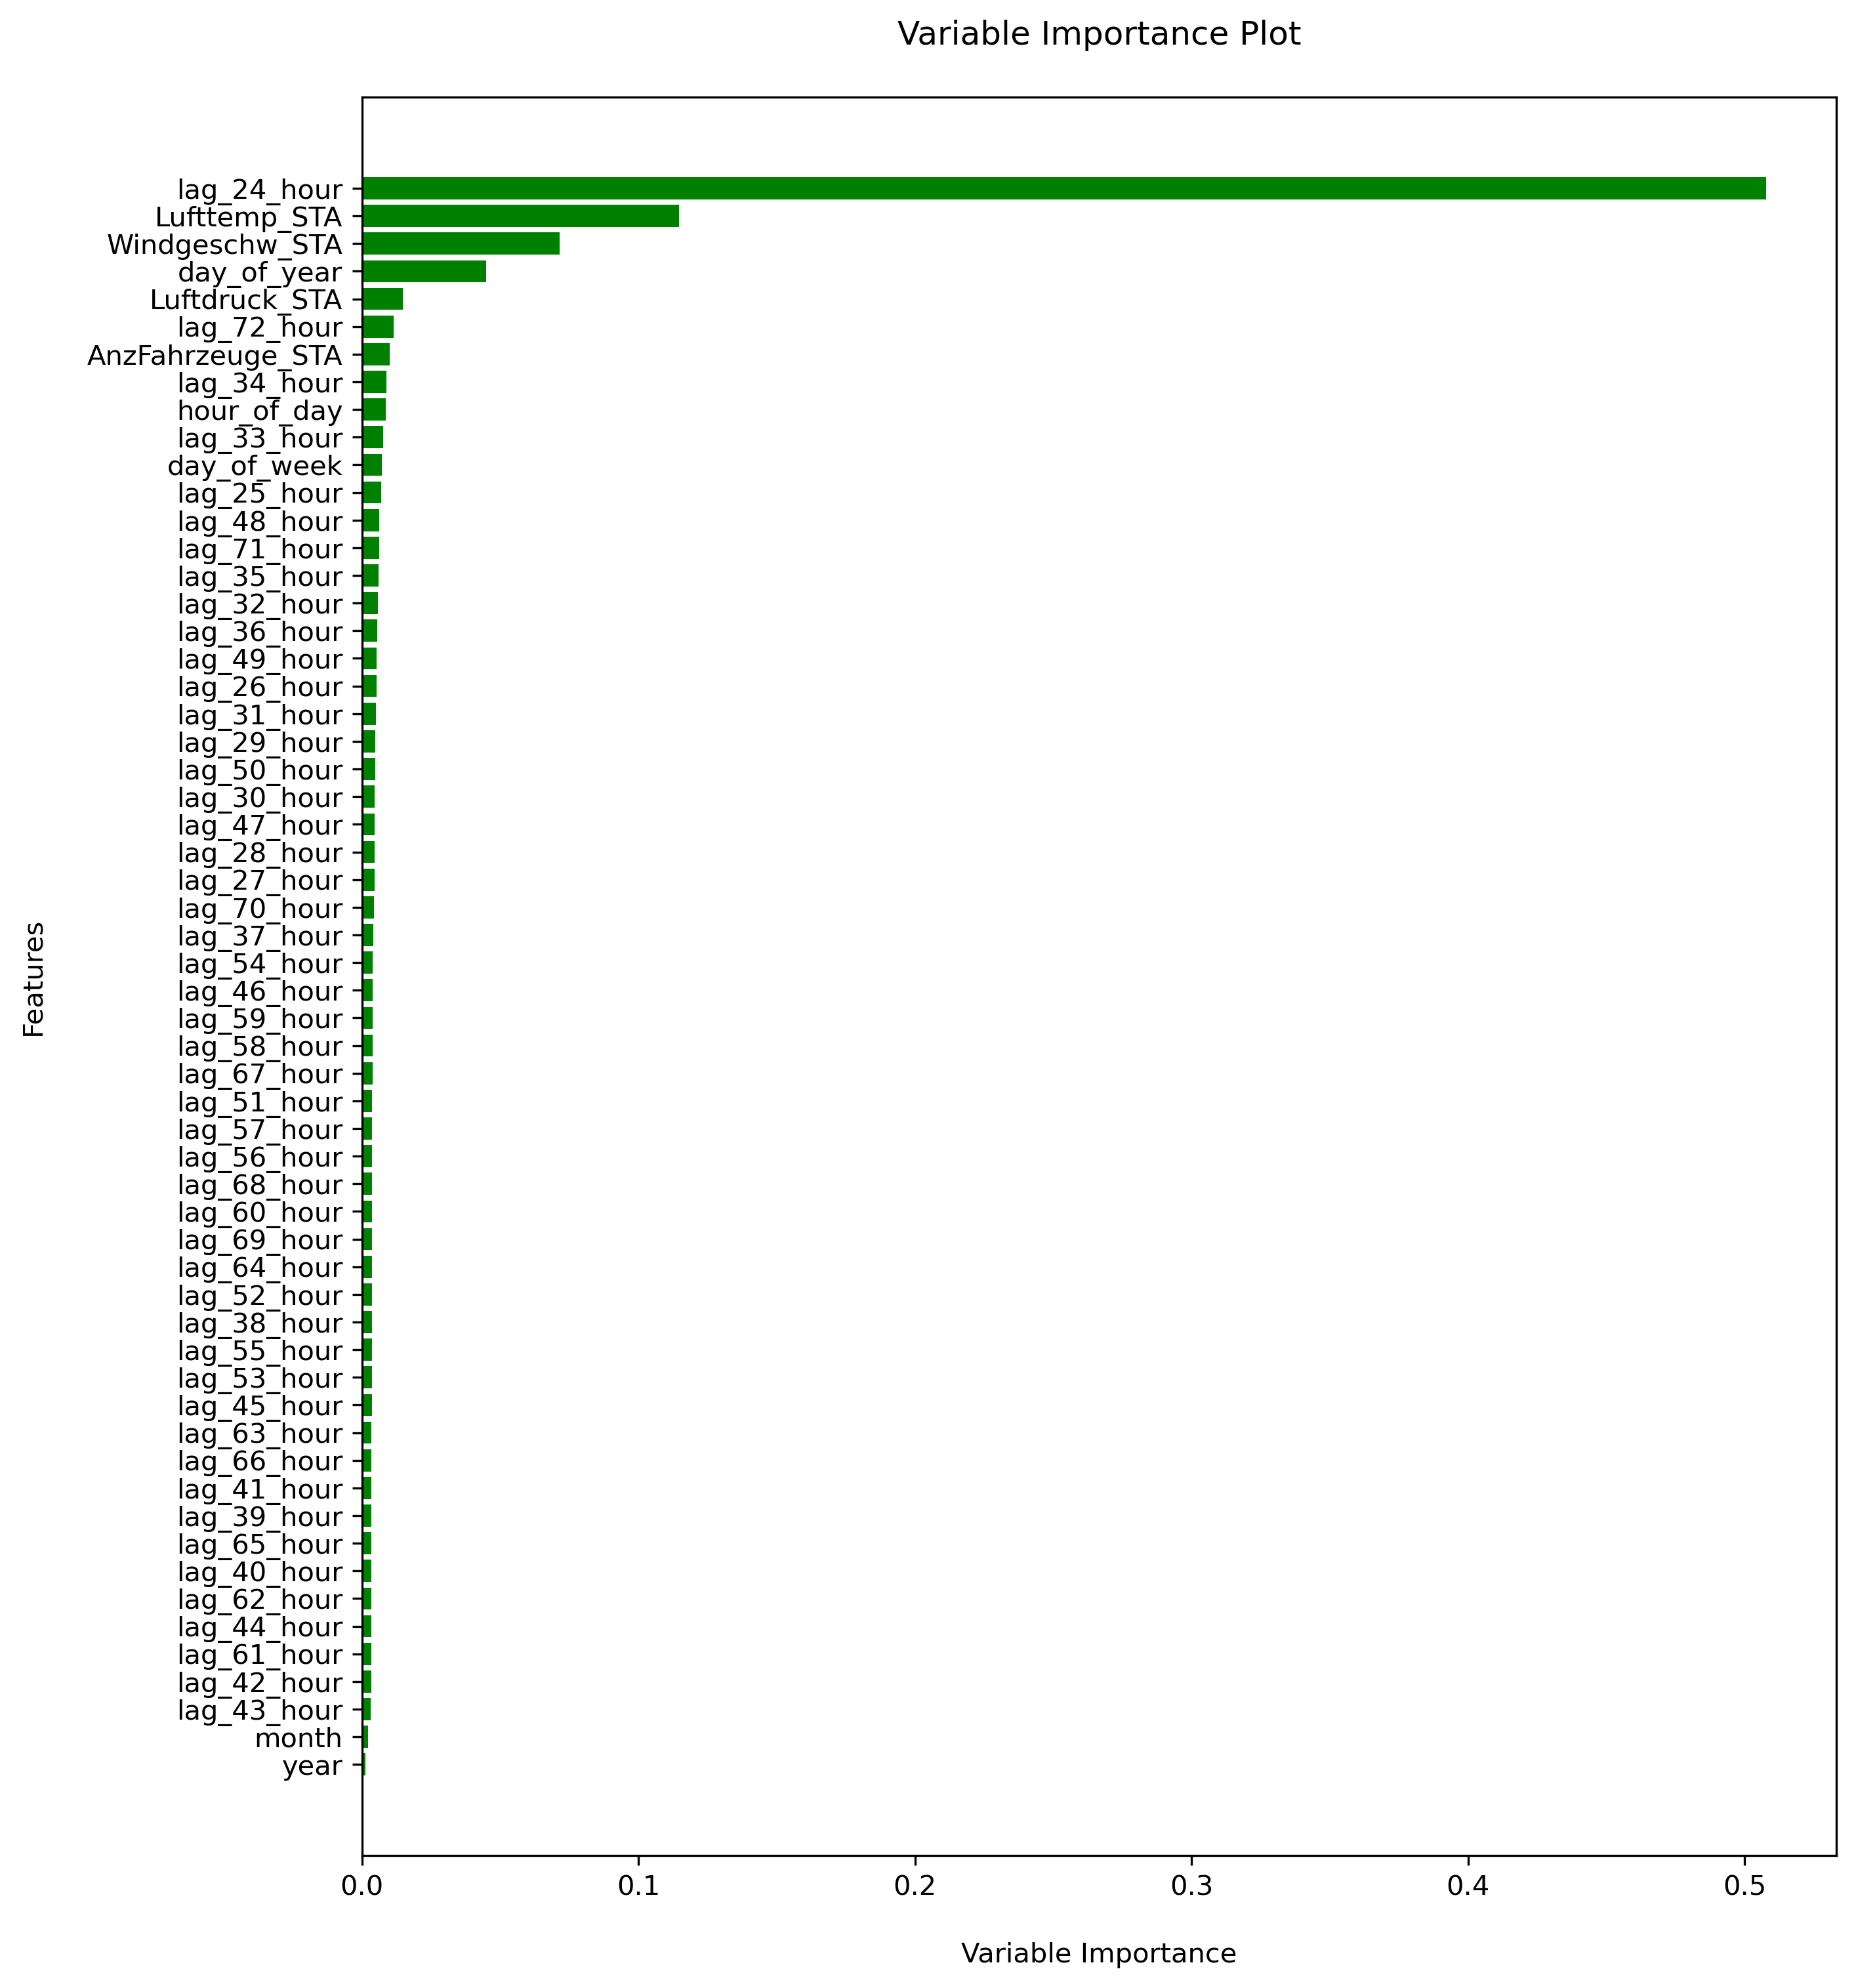

In [46]:
#We print our variable importance plot
plot_variable_importance(forecast_forest_sta2, X_train2)

Aus dem Variable Importance Plot ergibt sich, dass die Variablen lag 24h, Lufttemperatur, Windgeschwindigkeit, day of the year und Luftdruck am wichtigsten sind.

In [47]:
predictions_df2 = predictions_df2.explode('Predicted_Ozon')
predictions_df2 = predictions_df2.explode('Actual_Ozon')

# Reset the index
predictions_df2.reset_index(drop=True, inplace=True)

# Display the DataFrame after modification
print(predictions_df2)

      Day Hour Predicted_Ozon Actual_Ozon
0     340    0         5.8507        3.65
1     340    1        10.5845        2.87
2     340    2       9.844133       12.55
3     340    3      10.744067       28.25
4     340    4       7.063067        7.35
...   ...  ...            ...         ...
8635  334   19      18.627367         2.9
8636  334   20      33.985533        1.99
8637  334   21      33.072667        3.28
8638  334   22      34.696502        6.96
8639  334   23      26.556807        2.42

[8640 rows x 4 columns]


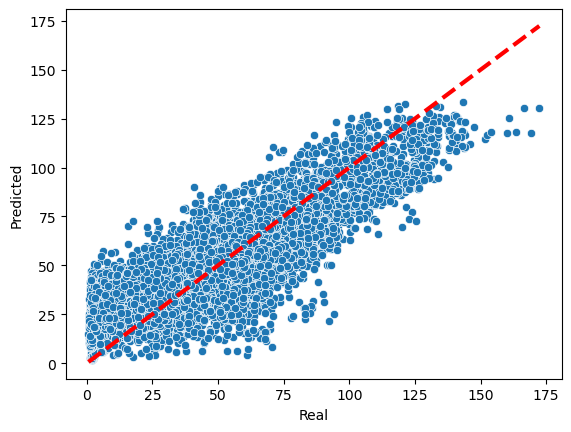

In [48]:
import seaborn as sns
#Visualization of the model
data_rf2 = pd.DataFrame({'Real': predictions_df2['Actual_Ozon'], 'Predicted': predictions_df2['Predicted_Ozon']})

sns.scatterplot(data=data_rf2, x='Real', y='Predicted')
plt.plot([test2['StampfenbachstrOzon'].min(), test2['StampfenbachstrOzon'].max()], [test2['StampfenbachstrOzon'].min(), test2['StampfenbachstrOzon'].max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

# N_Estimators = 400

In [49]:
test3 = df_sta[-8640:] # get last year
train3 = df_sta[0:-8640] # get data until first day of testing day

In [50]:
shifts3 = np.arange(24, 73).astype(int) #we set lags from 24 to 72 (1 day and 3 days)

In [51]:
#We create the lag values
shifted_data3 = {"lag_{}_hour".format(hour_shift): train3["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts3}

#We make a dataset with the lag values
shifted_data3 = pd.DataFrame(shifted_data3)
shifted_data3

lag_24_hour  lag_25_hour  lag_26_hour  lag_27_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         2.01         2.29         2.33         2.75   
2022-12-05 20:00:00         1.86         2.01         2.29         2.33   
2022-12-05 21:00:00         3.06         1.86         2.01         2.29   
2022-12-05 22:00:00         4.73         3.06         1.86         2.01   
2022-12-05 23:00:00         6.75         4.73         3.06         1.86   

                     lag_28_hour  lag_29_hour  lag_30_hour  lag_31_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         5.11         6.95         7.03         6.65   
2022-12-05 20:00:00         2.75         5.11         6.95         7.03   
2022-12-05 21:00:00         2.33         2.75         5.11         6.95   
2022-12-05 22:00:00         2.29         2.33         2.75         5.11   
2022-12-05 23:00:00         2.01         2.29         2.33         2.75   

                     lag_32_hour  lag_33_hour  ...  lag_63_hour  lag_64_hour  \
datetime                                       ...                             
2021-01-01 01:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN  ...          NaN          NaN   
...                          ...          ...  ...          ...          ...   
2022-12-05 19:00:00         6.37         5.79  ...         9.42         8.94   
2022-12-05 20:00:00         6.65         6.37  ...        10.09         9.42   
2022-12-05 21:00:00         7.03         6.65  ...        10.67        10.09   
2022-12-05 22:00:00         6.95         7.03  ...        13.06        10.67   
2022-12-05 23:00:00         5.11         6.95  ...        12.05        13.06   

                     lag_65_hour  lag_66_hour  lag_67_hour  lag_68_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         8.56         3.80         2.48         2.89   
2022-12-05 20:00:00         8.94         8.56         3.80         2.48   
2022-12-05 21:00:00         9.42         8.94         8.56         3.80   
2022-12-05 22:00:00        10.09         9.42         8.94         8.56   
2022-12-05 23:00:00        10.67        10.09         9.42         8.94   

                     lag_69_hour  lag_70_hour  lag_7

In [52]:
#We create our training set with the shifted data
train3 = pd.concat([train3,shifted_data3],axis=1)
train3.head()

Luftdruck_STA  Lufttemp_STA  Windgeschw_STA  \
datetime                                                           
2021-01-01 01:00:00          954.0           2.1             4.7   
2021-01-01 02:00:00          954.4           2.3             3.2   
2021-01-01 03:00:00          954.6           2.0             2.5   
2021-01-01 04:00:00          954.6           2.3             2.2   
2021-01-01 05:00:00          954.8           2.3             2.9   

                     StampfenbachstrOzon  AnzFahrzeuge_STA  hour_of_day  \
datetime                                                                  
2021-01-01 01:00:00                 8.51            1320.0            1   
2021-01-01 02:00:00                 5.34             919.0            2   
2021-01-01 03:00:00                 7.54             617.0            3   
2021-01-01 04:00:00                31.30             445.0            4   
2021-01-01 05:00:00                40.87             371.0            5   

                     day_of_week  day_of_year  month  year  ...  lag_63_hour  \
datetime                                                    ...                
2021-01-01 01:00:00            5            1      1  2021  ...          NaN   
2021-01-01 02:00:00            5            1      1  2021  ...          NaN   
2021-01-01 03:00:00            5            1      1  2021  ...          NaN   
2021-01-01 04:00:00            5            1      1  2021  ...          NaN   
2021-01-01 05:00:00            5            1      1  2021  ...          NaN   

                     lag_64_hour  lag_65_hour  lag_66_hour  lag_67_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   

                     lag_68_hour  lag_69_hour  lag_70_hour  lag_71_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   

                     lag_72_hour  
datetime                          
2021-01-01 01:00:00          NaN  
2021-01-01 02:00:00          NaN  
2021-01-01 03:00:00          NaN  
2021-01-01 04:00:00          NaN  
2021-01-01 05:00:00          NaN  

[5 rows x 59 columns]

In [53]:
#We drop the NaN values
train3 = train3.dropna()

In [54]:
#We create our X_train and y_train sets
X_train3 = train3.drop("StampfenbachstrOzon", axis=1)
y_train3 = train3["StampfenbachstrOzon"]

In [55]:
#We fit our model
forecast_forest_sta3 = RandomForestRegressor(n_estimators=400, random_state=1)
forecast_forest_sta3.fit(X_train3, y_train3)

RandomForestRegressor(n_estimators=400, random_state=1)

In [56]:
#We apply our forecasting function
performance_collector3, predictions_df3 = evaluate_forecast(train3, test3, shifts3, 72, forecast_forest_sta3)

Day 340, Hour 0, y_pred_hourly: [5.421525000000003]
Day 340, Hour 1, y_pred_hourly: [10.8213]
Day 340, Hour 2, y_pred_hourly: [9.722824999999993]
Day 340, Hour 3, y_pred_hourly: [10.466824999999995]
Day 340, Hour 4, y_pred_hourly: [6.6928250000000045]
Day 340, Hour 5, y_pred_hourly: [14.769512499999985]
Day 340, Hour 6, y_pred_hourly: [14.877874999999994]
Day 340, Hour 7, y_pred_hourly: [18.182774999999996]
Day 340, Hour 8, y_pred_hourly: [16.313625000000005]
Day 340, Hour 9, y_pred_hourly: [13.058624999999992]
Day 340, Hour 10, y_pred_hourly: [21.145725]
Day 340, Hour 11, y_pred_hourly: [19.124425000000006]
Day 340, Hour 12, y_pred_hourly: [21.94735000000001]
Day 340, Hour 13, y_pred_hourly: [23.80192500000001]
Day 340, Hour 14, y_pred_hourly: [22.55315000000002]
Day 340, Hour 15, y_pred_hourly: [20.720808333333338]
Day 340, Hour 16, y_pred_hourly: [22.29286666666667]
Day 340, Hour 17, y_pred_hourly: [19.659499999999998]
Day 340, Hour 18, y_pred_hourly: [21.088991666666665]
Day 340, H

In [57]:
#We print our mean performance collector
print(np.mean(performance_collector3))

15.445831794285995


In [58]:
#We print our predictions
print(predictions_df3)

      Day Hour        Predicted_Ozon Actual_Ozon
0     340    0   [5.421525000000003]      [3.65]
1     340    1             [10.8213]      [2.87]
2     340    2   [9.722824999999993]     [12.55]
3     340    3  [10.466824999999995]     [28.25]
4     340    4  [6.6928250000000045]      [7.35]
...   ...  ...                   ...         ...
8635  334   19  [17.733000000000025]       [2.9]
8636  334   20   [33.05902500000001]      [1.99]
8637  334   21            [33.22175]      [3.28]
8638  334   22  [33.643376190476204]      [6.96]
8639  334   23   [26.68258035714285]      [2.42]

[8640 rows x 4 columns]


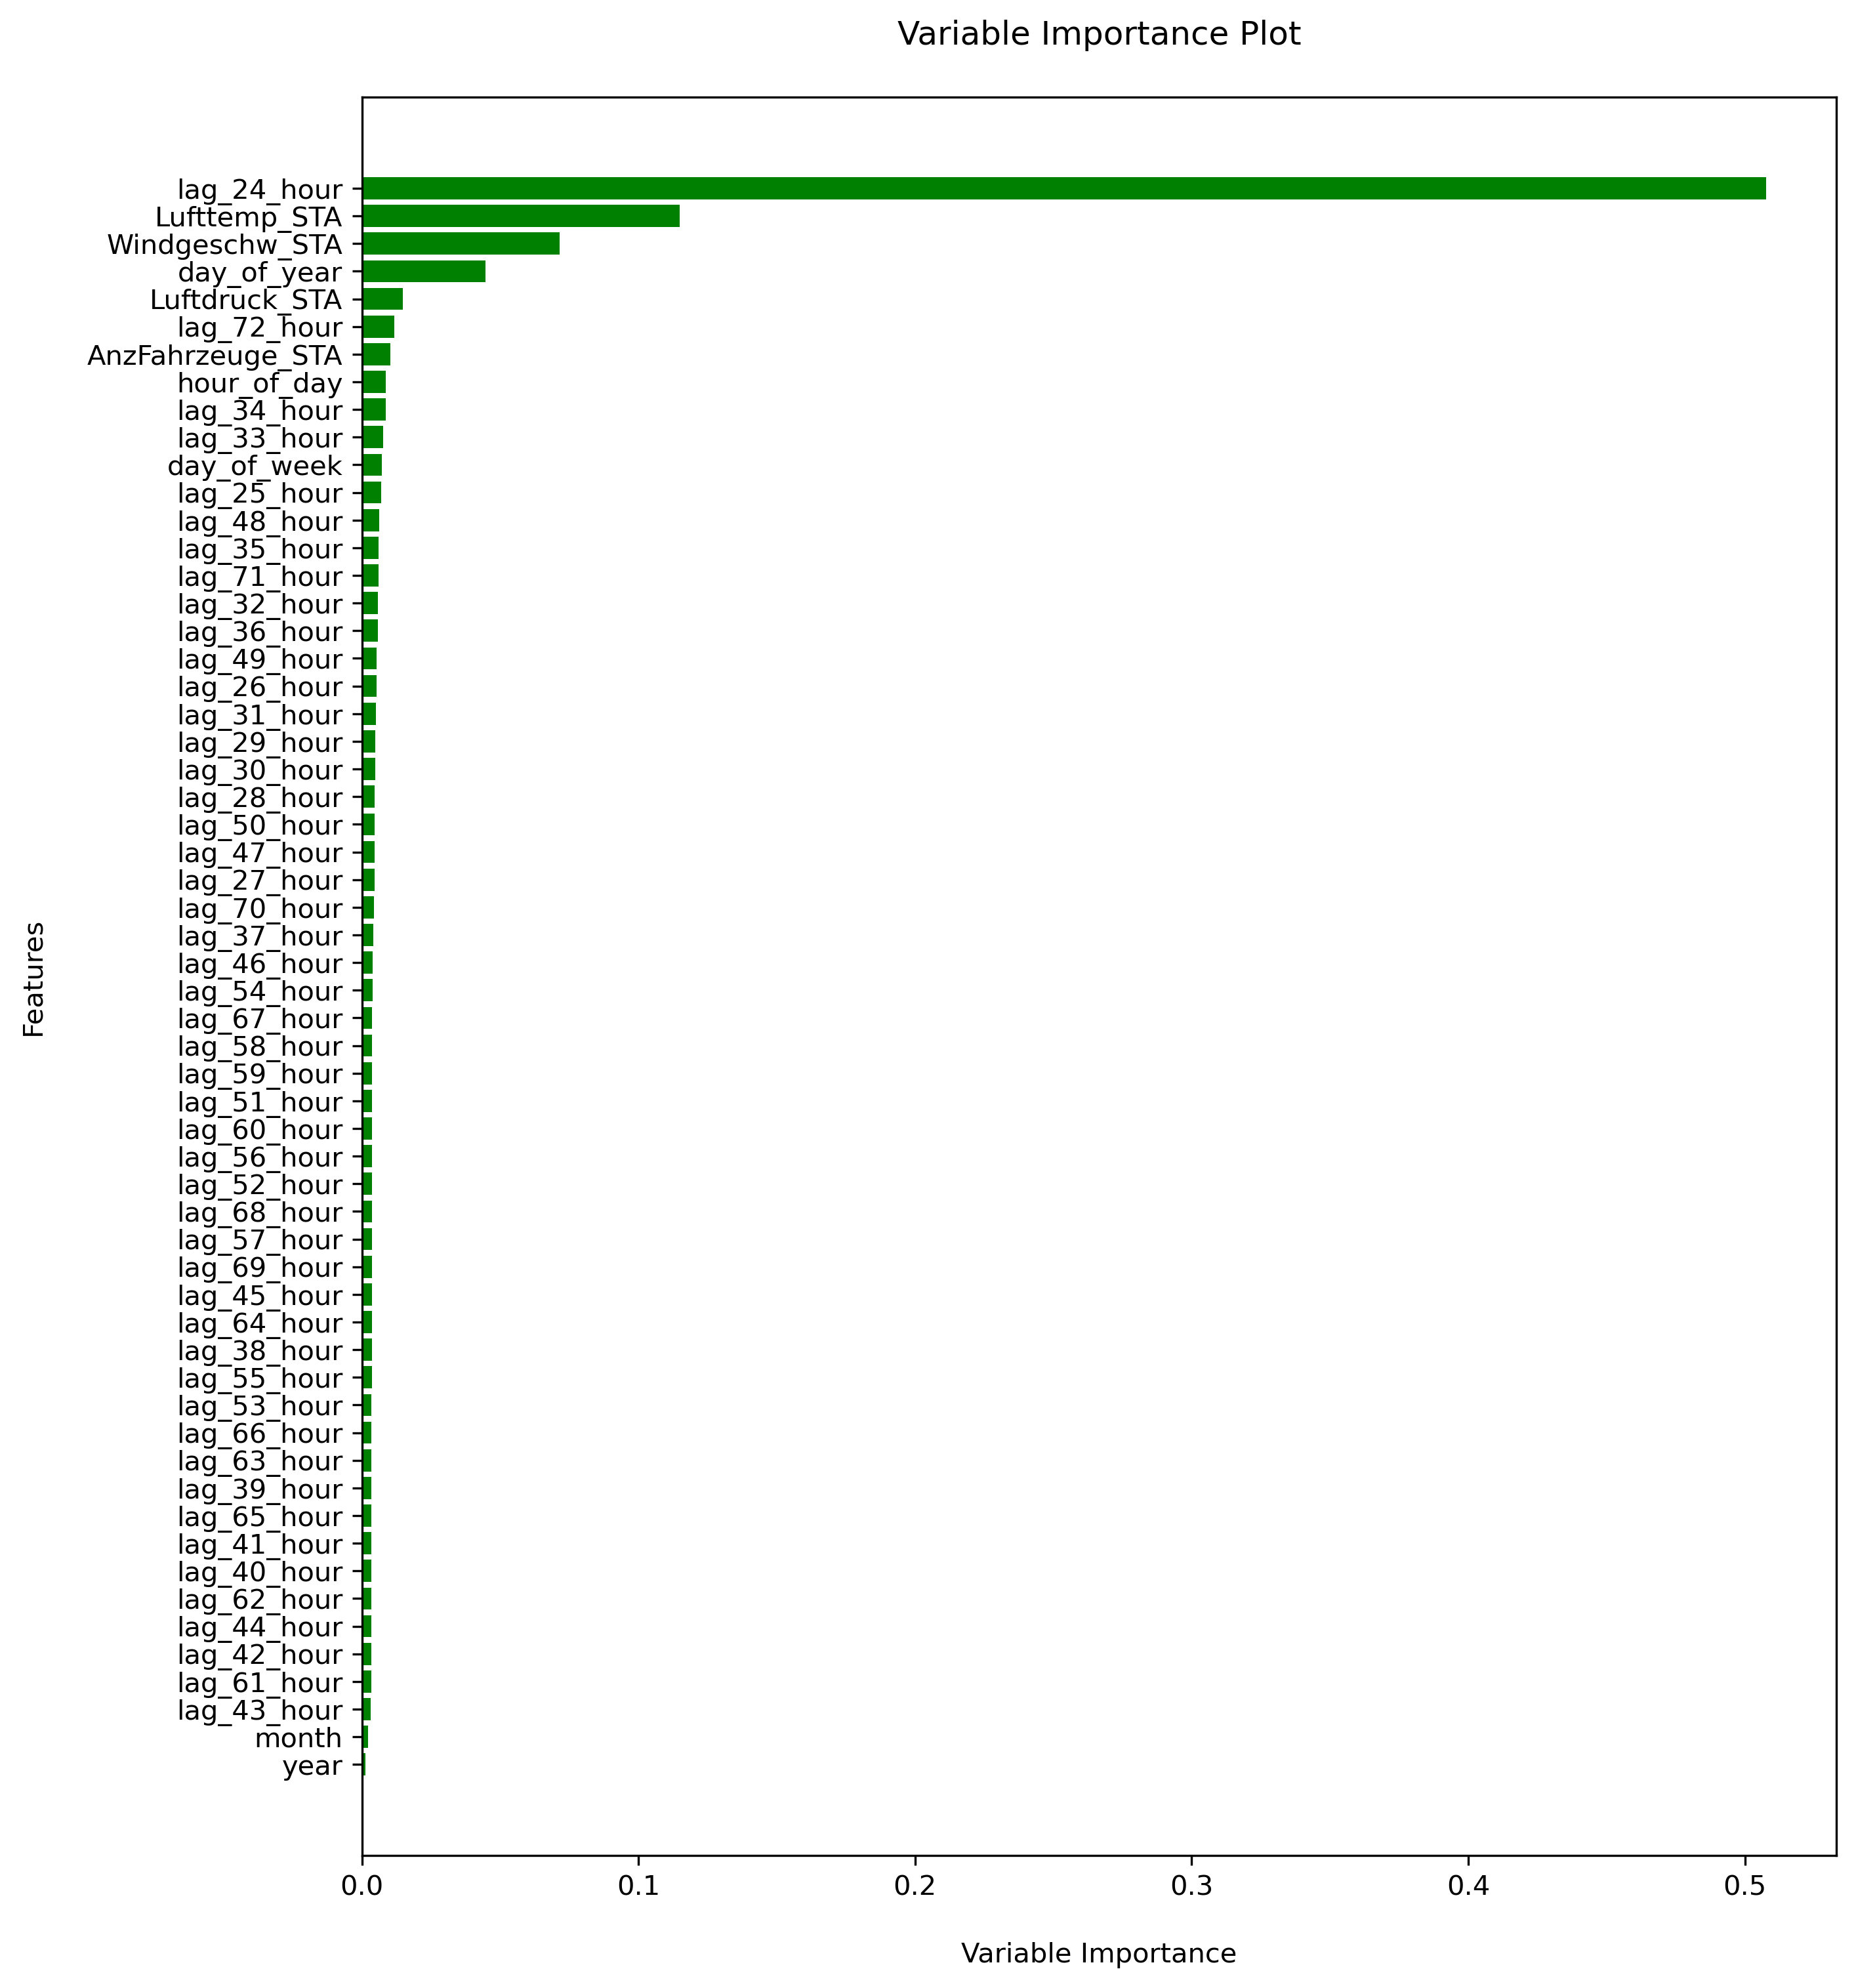

In [59]:
#We print our variable importance plot
plot_variable_importance(forecast_forest_sta3, X_train3)

Aus dem Variable Importance Plot ergibt sich, dass die Variablen lag 24h, Lufttemperatur, Windgeschwindigkeit, day of the year und Luftdruck am wichtigsten sind.

In [60]:
predictions_df3 = predictions_df3.explode('Predicted_Ozon')
predictions_df3 = predictions_df3.explode('Actual_Ozon')

# Reset the index
predictions_df3.reset_index(drop=True, inplace=True)

# Display the DataFrame after modification
print(predictions_df3)

      Day Hour Predicted_Ozon Actual_Ozon
0     340    0       5.421525        3.65
1     340    1        10.8213        2.87
2     340    2       9.722825       12.55
3     340    3      10.466825       28.25
4     340    4       6.692825        7.35
...   ...  ...            ...         ...
8635  334   19         17.733         2.9
8636  334   20      33.059025        1.99
8637  334   21       33.22175        3.28
8638  334   22      33.643376        6.96
8639  334   23       26.68258        2.42

[8640 rows x 4 columns]


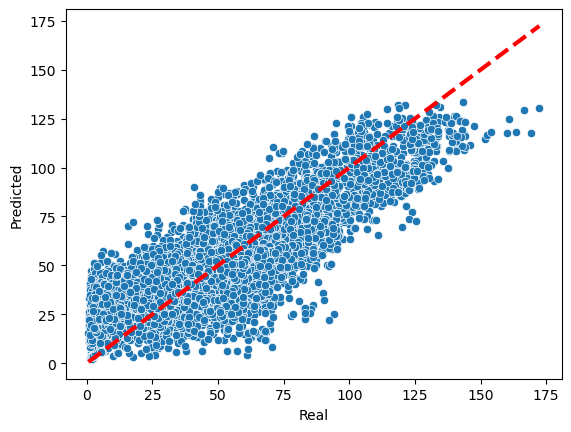

In [61]:
import seaborn as sns
#Visualization of the model
data_rf3 = pd.DataFrame({'Real': predictions_df3['Actual_Ozon'], 'Predicted': predictions_df3['Predicted_Ozon']})

sns.scatterplot(data=data_rf3, x='Real', y='Predicted')
plt.plot([test3['StampfenbachstrOzon'].min(), test3['StampfenbachstrOzon'].max()], [test3['StampfenbachstrOzon'].min(), test3['StampfenbachstrOzon'].max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

# Seasonality

In [62]:
test4 = df_sta[-8640:] # get last year
train4 = df_sta[0:-8640] # get data until first day of testing day

In [63]:
shifts4 = np.arange(24, 73).astype(int) #we set lags from 24 to 72 (1 day and 3 days)

In [64]:
#We create the lag values
shifted_data4 = {"lag_{}_hour".format(hour_shift): train4["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts4}

#We make a dataset with the lag values
shifted_data4 = pd.DataFrame(shifted_data4)
shifted_data4

lag_24_hour  lag_25_hour  lag_26_hour  lag_27_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         2.01         2.29         2.33         2.75   
2022-12-05 20:00:00         1.86         2.01         2.29         2.33   
2022-12-05 21:00:00         3.06         1.86         2.01         2.29   
2022-12-05 22:00:00         4.73         3.06         1.86         2.01   
2022-12-05 23:00:00         6.75         4.73         3.06         1.86   

                     lag_28_hour  lag_29_hour  lag_30_hour  lag_31_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         5.11         6.95         7.03         6.65   
2022-12-05 20:00:00         2.75         5.11         6.95         7.03   
2022-12-05 21:00:00         2.33         2.75         5.11         6.95   
2022-12-05 22:00:00         2.29         2.33         2.75         5.11   
2022-12-05 23:00:00         2.01         2.29         2.33         2.75   

                     lag_32_hour  lag_33_hour  ...  lag_63_hour  lag_64_hour  \
datetime                                       ...                             
2021-01-01 01:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN  ...          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN  ...          NaN          NaN   
...                          ...          ...  ...          ...          ...   
2022-12-05 19:00:00         6.37         5.79  ...         9.42         8.94   
2022-12-05 20:00:00         6.65         6.37  ...        10.09         9.42   
2022-12-05 21:00:00         7.03         6.65  ...        10.67        10.09   
2022-12-05 22:00:00         6.95         7.03  ...        13.06        10.67   
2022-12-05 23:00:00         5.11         6.95  ...        12.05        13.06   

                     lag_65_hour  lag_66_hour  lag_67_hour  lag_68_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         8.56         3.80         2.48         2.89   
2022-12-05 20:00:00         8.94         8.56         3.80         2.48   
2022-12-05 21:00:00         9.42         8.94         8.56         3.80   
2022-12-05 22:00:00        10.09         9.42         8.94         8.56   
2022-12-05 23:00:00        10.67        10.09         9.42         8.94   

                     lag_69_hour  lag_70_hour  lag_7

In [65]:
train4 = pd.concat([train4,shifted_data4],axis=1)
train4

Luftdruck_STA  Lufttemp_STA  Windgeschw_STA  \
datetime                                                           
2021-01-01 01:00:00          954.0           2.1             4.7   
2021-01-01 02:00:00          954.4           2.3             3.2   
2021-01-01 03:00:00          954.6           2.0             2.5   
2021-01-01 04:00:00          954.6           2.3             2.2   
2021-01-01 05:00:00          954.8           2.3             2.9   
...                            ...           ...             ...   
2022-12-05 19:00:00          968.6           5.7             3.6   
2022-12-05 20:00:00          968.9           5.3             2.9   
2022-12-05 21:00:00          969.0           4.4             3.6   
2022-12-05 22:00:00          969.0           4.0             3.2   
2022-12-05 23:00:00          968.9           3.5             1.4   

                     StampfenbachstrOzon  AnzFahrzeuge_STA  hour_of_day  \
datetime                                                                  
2021-01-01 01:00:00                 8.51            1320.0            1   
2021-01-01 02:00:00                 5.34             919.0            2   
2021-01-01 03:00:00                 7.54             617.0            3   
2021-01-01 04:00:00                31.30             445.0            4   
2021-01-01 05:00:00                40.87             371.0            5   
...                                  ...               ...          ...   
2022-12-05 19:00:00                22.99            2781.0           19   
2022-12-05 20:00:00                22.99            2204.0           20   
2022-12-05 21:00:00                12.72            2209.0           21   
2022-12-05 22:00:00                 4.00            1971.0           22   
2022-12-05 23:00:00                 2.53            1214.0           23   

                     day_of_week  day_of_year  month  year  ...  lag_63_hour  \
datetime                                                    ...                
2021-01-01 01:00:00            5            1      1  2021  ...          NaN   
2021-01-01 02:00:00            5            1      1  2021  ...          NaN   
2021-01-01 03:00:00            5            1      1  2021  ...          NaN   
2021-01-01 04:00:00            5            1      1  2021  ...          NaN   
2021-01-01 05:00:00            5            1      1  2021  ...          NaN   
...                          ...          ...    ...   ...  ...          ...   
2022-12-05 19:00:00            1          339     12  2022  ...         9.42   
2022-12-05 20:00:00            1          339     12  2022  ...        10.09   
2022-12-05 21:00:00            1          339     12  2022  ...        10.67   
2022-12-05 22:00:00            1          339     12  2022  ...        13.06   
2022-12-05 23:00:00            1          339     12  2022  ...        12.05   

                     lag_64_hour  lag_65_hour  lag_66_hour  lag_67_hour  \
datetime                                                                  
2021-01-01 01:00:00          NaN          NaN          NaN          NaN   
2021-01-01 02:00:00          NaN          NaN          NaN          NaN   
2021-01-01 03:00:00          NaN          NaN          NaN          NaN   
2021-01-01 04:00:00          NaN          NaN          NaN          NaN   
2021-01-01 05:00:00          NaN          NaN          NaN          NaN   
...                          ...          ...          ...          ...   
2022-12-05 19:00:00         8.94         8.56         3.80         2.48   
2022-12-05 20:00:00         9.42         8.94         8.56         3.80   
2022-12-05 21:00:00        10.09         9.42         8.94         8.56   
2022-12-05 22:00:00        10.67        10.09         9.42         8.94   
2022-12-05 23:00:00        13.06        10.67        10.09         9.42   

                     lag_68_hour  lag_69_hour  lag_70_hour  lag_71_hour  \
datetime                                                            

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
#We add the seasonal component
decomp = seasonal_decompose(df_sta["StampfenbachstrOzon"])
train4["seasonality"] = decomp.seasonal

In [67]:
#We drop the NaN values
train4 = train4.dropna()

In [68]:
#We create our X_train and y_train sets
X_train4 = train4.drop("StampfenbachstrOzon", axis=1)
y_train4 = train4["StampfenbachstrOzon"]

In [69]:
#We set the necessary conditions for our walk-forward
history = train4
performance_collector = []

In [70]:
#We fit our model
forecast_forest_sta4 = RandomForestRegressor(n_estimators=300, random_state=1)
forecast_forest_sta4.fit(X_train4, y_train4)

RandomForestRegressor(n_estimators=300, random_state=1)

In [71]:
#We define the dataset for our predictions
hourly_predictions_df = pd.DataFrame(columns=['Day', 'Hour', 'Predicted_Ozon', 'Actual_Ozon'])

In [72]:
#The code was taken from the Forecasting Notebook of Module 8
for d in test4["day_of_year"].unique():
    dat = history.tail(72)  # get last 72 hours of available data
    dat = pd.concat([dat, test4[test4["day_of_year"] == d]])  # add test data

    shifted_data4 = {"lag_{}_hour".format(hour_shift): dat["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts4}  # lag training data
    shifted_data4 = pd.DataFrame(shifted_data4)

    dat = pd.concat([dat[["Luftdruck_STA", "Lufttemp_STA", "Windgeschw_STA", "StampfenbachstrOzon", "AnzFahrzeuge_STA", "hour_of_day", "day_of_week", "day_of_year", "month", "year"]], shifted_data4], axis=1)
    
    dat = dat.dropna()  # delete missing data
    
    dat["seasonality"] = decomp.seasonal.head(24).values

    pred_dat = dat.drop("StampfenbachstrOzon", axis=1)

    y_pred4 = forecast_forest_sta4.predict(pred_dat)
    actual4 = test4[test4["day_of_year"] == d]["StampfenbachstrOzon"]
    

    # Evaluate performance using mean squared error for each hour
    for h in range(24):
        actual_hourly4 = test4[(test4["hour_of_day"] == h) & (test4["day_of_year"] == d)]["StampfenbachstrOzon"]
        y_pred_hourly4 = y_pred4[h::24]  # Extract predictions for the current hour from the 24-hour prediction
        print(f'Day {d}, Hour {h}, y_pred_hourly: {y_pred_hourly4.tolist()}')
        hourly_predictions_df = pd.concat([hourly_predictions_df, pd.DataFrame({"Day": [d], "Hour": [h], "Predicted_Ozon": [y_pred_hourly4.tolist()], "Actual_Ozon": [actual_hourly4.tolist()]})], ignore_index=True)
        
    performance_collector.append(mean_squared_error(actual4,y_pred4, squared=False))

    history = pd.concat([history, dat], ignore_index=True) #append funktionierte nicht



Day 340, Hour 0, y_pred_hourly: [5.544266666666666]
Day 340, Hour 1, y_pred_hourly: [10.028333333333329]
Day 340, Hour 2, y_pred_hourly: [10.966766666666663]
Day 340, Hour 3, y_pred_hourly: [11.519833333333331]
Day 340, Hour 4, y_pred_hourly: [7.456400000000005]
Day 340, Hour 5, y_pred_hourly: [13.61971666666666]
Day 340, Hour 6, y_pred_hourly: [13.285616666666654]
Day 340, Hour 7, y_pred_hourly: [16.452749999999995]
Day 340, Hour 8, y_pred_hourly: [15.361583333333325]
Day 340, Hour 9, y_pred_hourly: [12.203449999999993]
Day 340, Hour 10, y_pred_hourly: [20.73306666666669]
Day 340, Hour 11, y_pred_hourly: [19.962538095238088]
Day 340, Hour 12, y_pred_hourly: [23.84323333333333]
Day 340, Hour 13, y_pred_hourly: [25.100877777777747]
Day 340, Hour 14, y_pred_hourly: [24.17193333333332]
Day 340, Hour 15, y_pred_hourly: [22.943438095238083]
Day 340, Hour 16, y_pred_hourly: [22.81901587301587]
Day 340, Hour 17, y_pred_hourly: [20.608771428571437]
Day 340, Hour 18, y_pred_hourly: [20.85956984

In [73]:
#We print our performance collector
print(performance_collector)

[8.058553070267466, 9.346384721966109, 11.001964702997155, 10.731066620077828, 18.842538295218063, 11.342831609934635, 12.171019541429493, 10.566594230363133, 17.912201458232985, 19.286810815801996, 17.31261442318652, 9.629574249770954, 9.263369155460419, 16.543959362713494, 16.48006638046863, 15.867870518009275, 15.058458910583262, 11.734612934562529, 15.673391010264337, 17.242839605552152, 19.64960866602456, 30.77263235656389, 16.06625192179801, 12.072978962759628, 21.235801180675434, 14.107790374232518, 21.825920337209954, 20.91234130822506, 34.7637785937009, 16.449401473173506, 12.549191524345462, 24.488868423712983, 14.655728084934427, 16.840940483986895, 23.814987021752085, 15.408265818993323, 14.11485977310168, 11.819245787161297, 10.244891342786435, 10.350379497783171, 16.0410919798955, 17.82682363511154, 19.725671020266386, 18.35239170101965, 17.613643075215165, 18.457854052064143, 15.880778398840729, 8.971719347496713, 9.317397992448099, 10.592288992565008, 9.19327770110775, 

In [74]:
#We print the mean of the performance collector
print(np.mean(performance_collector))

15.428315256920488


In [75]:
#We print our hourly predictions
hourly_predictions_df

Day Hour        Predicted_Ozon Actual_Ozon
0     340    0   [5.544266666666666]      [3.65]
1     340    1  [10.028333333333329]      [2.87]
2     340    2  [10.966766666666663]     [12.55]
3     340    3  [11.519833333333331]     [28.25]
4     340    4   [7.456400000000005]      [7.35]
...   ...  ...                   ...         ...
8635  334   19   [19.52620000000002]       [2.9]
8636  334   20   [33.40676666666668]      [1.99]
8637  334   21   [33.22486666666667]      [3.28]
8638  334   22  [35.426149999999986]      [6.96]
8639  334   23  [27.618577777777798]      [2.42]

[8640 rows x 4 columns]

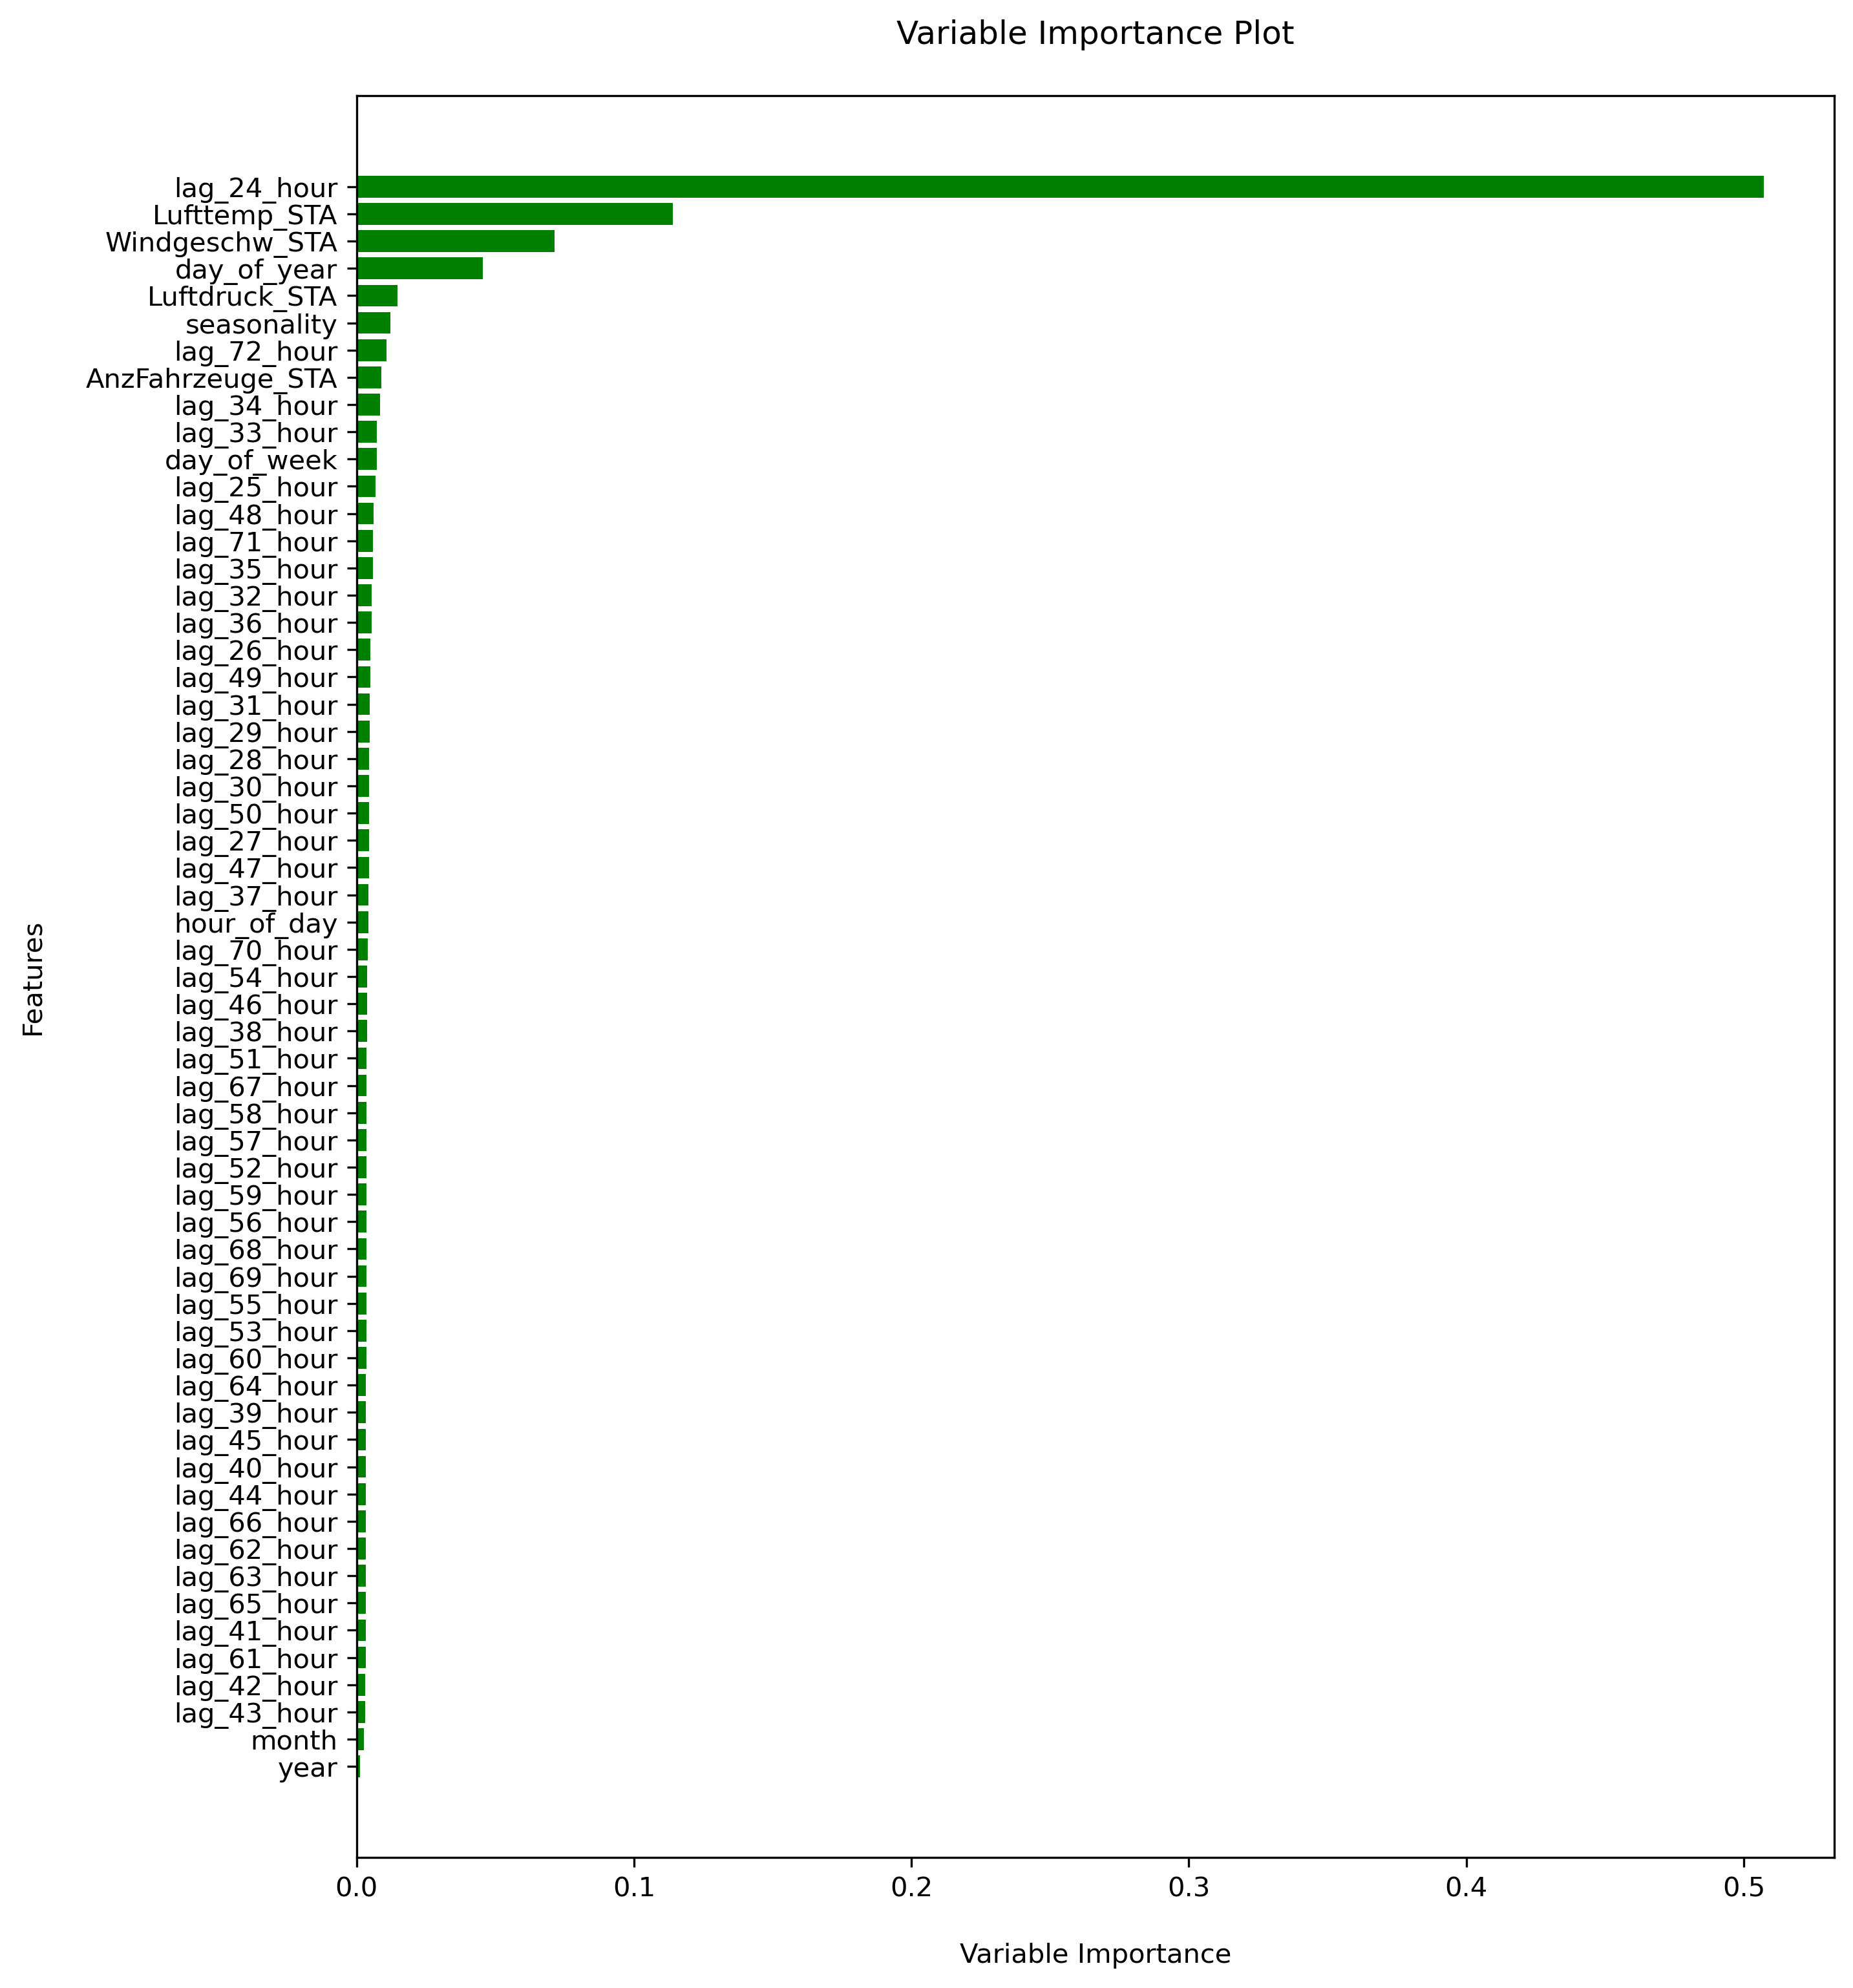

In [76]:
#We plot our variable importance plot
plot_variable_importance(forecast_forest_sta4, X_train4)

Aus dem Variable Importance Plot ergibt sich, dass die Variablen lag 24h, Lufttemperatur, Windgeschwindigkeit, day of the year und Luftdruck am wichtigsten sind.

In [77]:
#We remove the [] from our dataset
hourly_predictions_df = hourly_predictions_df.explode('Predicted_Ozon')
hourly_predictions_df = hourly_predictions_df.explode('Actual_Ozon')

# Reset the index
hourly_predictions_df.reset_index(drop=True, inplace=True)

# Display the DataFrame after modification
print(hourly_predictions_df)

      Day Hour Predicted_Ozon Actual_Ozon
0     340    0       5.544267        3.65
1     340    1      10.028333        2.87
2     340    2      10.966767       12.55
3     340    3      11.519833       28.25
4     340    4         7.4564        7.35
...   ...  ...            ...         ...
8635  334   19        19.5262         2.9
8636  334   20      33.406767        1.99
8637  334   21      33.224867        3.28
8638  334   22       35.42615        6.96
8639  334   23      27.618578        2.42

[8640 rows x 4 columns]


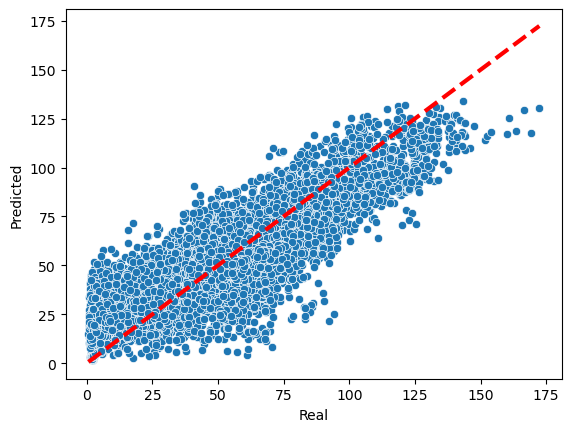

In [78]:
import seaborn as sns
#We visualize our model
data_rf4 = pd.DataFrame({'Real': hourly_predictions_df['Actual_Ozon'], 'Predicted': hourly_predictions_df['Predicted_Ozon']})

sns.scatterplot(data=data_rf4, x='Real', y='Predicted')
plt.plot([test4['StampfenbachstrOzon'].min(), test4['StampfenbachstrOzon'].max()], [test4['StampfenbachstrOzon'].min(), test4['StampfenbachstrOzon'].max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

Durch die Einführung von mehreren Estimators wurde die Performance der Modelle nnur leicht verbessert. 
Insgesamt ist das Folgende zu merken: Die ersten 24 Lags wären am wichtigsten gewesen, um die Performance der Modelle zu verbessern. Das Neutrainieren der Modelle beim Walk-Forward loop wäre auch vorteilhaft gewesen.